In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import math
import re

Объявим основные классы, описывающие проблему (заказчик, проблема(название, склад, заказчики), путь)

In [76]:
class Customer:
    def __init__(self, number, x, y, demand, readyTime, dueDate, serviceTime):
        self.number = number
        self.x = x
        self.y = y
        self.demand = demand
        self.readyTime = readyTime
        self.dueDate = dueDate
        self.serviceTime = serviceTime
        self.isVisited = False
        self.clusterLabel = 0
    def distance(self, point):
        return math.sqrt(math.pow(self.x - point.x, 2) + math.pow(self.y - point.y, 2))
    
    def time(self, point, time):
        return (max([point.readyTime, time + self.distance(point)]) + point.serviceTime)
    
    
class Problem:
    def __init__(self, name, customers: list, vehicleNumber, vehicleCapacity):
        self.name = name
        self.customers = customers
        self.vehicleNumber = vehicleNumber
        self.vehicleCapacity = vehicleCapacity
        self.depot: Customer = [x for x in customers if (x.number == 0)][0]
        self.depot.isVisited = True
        
    def getAvaliable(self):
        return sorted(filter(lambda x: not x.isVisited, self.customers[1:]), key=lambda x: x.dueDate)
    
    def getNearest(self, currentCustomer, avaliables, currentTime):

        info = []
        for customer in avaliables:
            #time = max([target.readyTime, time + source.distance(target)]) + target.serviceTime
            info.append([max([round(currentCustomer.distance(customer),8), customer.readyTime]), customer.readyTime, customer.dueDate])

        if(len(info)==0):
            return self.depot
        minimum = np.finfo(np.float32).max

        for i in info:
            if(i[1]<=currentTime + i[0]  and i[2] >=currentTime ):

                minimum = min(minimum, i[0])
        ind = len(info)
        for i in range(len(info)):
            if(info[i][0] == minimum):
                ind = i
                break
        if(ind<len(info)):
            return avaliables[ind]
        return self.depot
    
    def getCluster(self, clusterIndex):
        return [x for x in self.customers[1:] if x.clusterLabel == clusterIndex and x.isVisited == False]
    
    def objectiveFunction(self, routes):
        sum = 0
        for route in routes:
            sum += route.total_distance
        return sum

Функция для чтения исходного файла в объект класса "Problem"

In [3]:
def readData(fileName) -> Problem:
        with open(fileName, 'r') as f:
            lines = list(map(lambda l: l.replace('\n', '').split(), f.readlines()))
        name = lines[0][0]
        vehicle_number, vehicle_capacity = list(map(int, lines[4]))
        customers = []
        for line in lines[9:]:
            customers.append(Customer(*list(map(int, line))))
        return Problem(name, customers, vehicle_number, vehicle_capacity)

In [4]:
class Route:
    def __init__(self, problem: Problem, customers: list):
        self.problem: Problem = problem
        self._customers: list = [self.problem.depot, *customers, self.problem.depot]
    @property
    def getRouteCustomers(self):
        return " ".join(str(customer.number) for customer in self._customers)

    def prePrintView(self):
        time = 0
        result = [0, 0.0]
        for source, target in zip(self._customers, self._customers[1:]):
            start_time = max([target.readyTime, time + source.distance(target)])
            time = start_time + target.serviceTime
            result.append(target.number)
            result.append(start_time)
        return " ".join(str(x) for x in result)

    @property
    def customers(self):
        return self._customers[1:-1]
    
    def allRouteCustomers(self):
        return self._customers
    @property
    def total_distance(self):
        return sum(a.distance(b) for (a, b) in zip(self._customers, self._customers[1:]))
    @property
    def is_feasible(self):
        time = 0
        capacity = self.problem.vehicleCapacity
        is_feasible = True
        for source, target in zip(self._customers, self._customers[1:]):
            start_time = max([target.readyTime, time + source.distance(target)])
            if start_time >= target.dueDate:
                is_feasible = False
            time = start_time + target.serviceTime
            capacity -= target.demand
        if time >= self.problem.depot.dueDate or capacity < 0:
            is_feasible = False
        return is_feasible

Прочитаем тестовый файл

In [ ]:
problem = readData("D://C108.txt")
problem

Ограничение на количество машин, ограничение на вместимость машины, сколько машин нужно, чтобы перевезти все заказы

Объявим функцию для отрисовки заказчиков по кластерам

In [5]:
def plot_cluster(x, labels, colors_count):

    plt.scatter(x[:, 0], x[:, 1], c=labels, cmap=plt.cm.get_cmap("jet", colors_count))
    plt.colorbar(ticks=range(colors_count))
    iter = 1
    for point in x:
        plt.text(point[0], point[1], iter)
        iter +=1
    plt.show()

In [ ]:
sums = [0 for i in range(0,math.ceil(averageCars))]
for x in problem.customers[1:]:    
    sums[x.clusterLabel] += x.demand

Объявим функцию для получения стартового решения ( с учётом деления на кластеры и ограничения по весу)

Объявим функцию для отрисовки маршрутов

In [6]:
def plotRoutes(routes):
    for route in routes:
        coordsX = []
        coordsY = []
        for customer in route.allRouteCustomers():
            coordsX.append(customer.x)
            coordsY.append(customer.y)
            plt.text(customer.x, customer.y, customer.number)
        plt.plot(coordsX, coordsY)
    plt.show()

In [ ]:
plotRoutes(getStartSolution(problem))

*Local Search*

Вспомогательные функции

In [7]:
def two_opt(a, i, j):
    if i == 0:
        return a[j:i:-1] + [a[i]] + a[j + 1:]
    return a[:i] + a[j:i - 1:-1] + a[j + 1:]


def cross(a, b, i, j):
    return a[:i] + b[j:], b[:j] + a[i:]


def insertion(a, b, i, j):
    if len(a) == 0:
        return a, b
    while i >= len(a):
        i -= len(a)
    return a[:i] + a[i + 1:], b[:j] + [a[i]] + b[j:]


def swap(a, b, i, j):
    if i >= len(a) or j >= len(b):
        return a, b
    a, b = a.copy(), b.copy()
    a[i], b[j] = b[j], a[i]
    return a, b

Объявим классы для осуществления локального поиска

In [68]:
class LocalSearch:
    def __init__(self, problem: Problem):
        self.problem: Problem = problem

    def optimize(self, routes: list) -> list:
        newRoutes = list(routes)
        for i in range(len(newRoutes)):
            stopped = False
            while not stopped:
                route = newRoutes[i]
                stopped = True
                for k, j in itertools.combinations(range(len(route.customers)), 2):
                    newRoute = Route(self.problem, two_opt(route.customers, k, j))
                    if newRoute.is_feasible:

                        if newRoute.total_distance < route.total_distance:
                            newRoutes[i] = newRoute
                            stopped = False
        return newRoutes


In [69]:
class IteratedLocalSearch(LocalSearch):
    def __init__(self, problem: Problem, objectiveFunction=None):
        super().__init__(problem)
        if not objectiveFunction:
            objectiveFunction = self.problem.objectiveFunction
        self.objectiveFunction = objectiveFunction
        self.initial_solution = getStartSolution(problem)

    def perturbation(self, routes: list) -> list:
        best = [Route(self.problem, route.customers) for route in routes]
        is_stucked = False
        while not is_stucked:
            is_stucked = True
            # Для всех возможных пар маршрутов
            for i, j in itertools.combinations(range(len(best)), 2):
                # Для всех возможных индексов в двух маршрутах
                for k, l in itertools.product(range(len(best[i].customers) + 2), range(len(best[j].customers) + 2)):
                    for func in [cross, insertion, swap]:
                        c1, c2 = func(best[i].customers, best[j].customers, k, l)
                        r1, r2 = Route(self.problem, c1), Route(self.problem, c2)
                        if r1.is_feasible and r2.is_feasible:
                            if r1.total_distance + r2.total_distance < best[i].total_distance + best[j].total_distance:
                                best[i] = r1
                                best[j] = r2
                                is_stucked = False
            best = list(filter(lambda x: len(x.customers) != 0, best))
        return best

    def execute(self):
        best = self.optimize(self.initial_solution)
        is_stucked = False
        while not is_stucked:
            is_stucked = True
            new_solution = self.perturbation(best)
            new_solution = self.optimize(new_solution)
            if self.objectiveFunction(new_solution) < self.objectiveFunction(best):
                is_stucked = False
                best = list(filter(lambda x: len(x.customers) != 0, new_solution))

        return best

In [70]:
def getStartSolution(problem):
    averageCars = np.sum([x.demand for x in problem.customers])/int(problem.vehicleCapacity)
    coords = np.column_stack([[c.x for c in problem.customers[1:] ], [ c.y for c in problem.customers[1:] ]])
    
    kmeans = KMeans( n_clusters = math.ceil(averageCars), random_state=0).fit(coords)
    for i in range(len(kmeans.labels_)):
        problem.customers[i+1].clusterLabel = kmeans.labels_[i]
        
    sums = [0 for i in range(0,math.ceil(averageCars))]
    for x in problem.customers[1:]:    
        sums[x.clusterLabel] += x.demand
        
    routes = []
    route = []
    costs = 0

    while len(problem.getAvaliable()) >0:
        costs = 0
        route.clear()
        weight = 0 
        current = problem.getAvaliable()[0]

        nearest = problem.getCluster(current.clusterLabel)
        if(len([x for x in nearest if x.isVisited == False])==1):
            route.append(current)
            problem.customers[problem.customers.index(current)].isVisited = True
        else:
            current = problem.getNearest(problem.depot, nearest, costs)

            costs = problem.depot.time(current, costs)
            route.append(current)
            problem.customers[problem.customers.index(current)].isVisited = True
            nearest.remove(current)
            weight += current.demand
            last = current
            if(len(problem.getAvaliable()) >0):
                while len(nearest)>0:
                    neighbor = problem.getNearest(last, nearest, costs)

                    if( neighbor.number == problem.depot.number):
                        break
                    if(weight == problem.vehicleCapacity or weight + neighbor.demand > problem.vehicleCapacity):
                        nearest.clear();
                    else:
                        if(neighbor in problem.getAvaliable()):

                            weight += neighbor.demand
                            costs = last.time(neighbor, costs)
                            route.append(neighbor)                 
                            problem.customers[problem.customers.index(neighbor)].isVisited = True
                            last = neighbor

                            nearest.remove(neighbor)

            if(weight< problem.vehicleCapacity and sums[current.clusterLabel]>weight):
                avs = problem.getAvaliable()
                stop = False
                while stop == False:

                    neighbor = problem.getNearest(last, avs, costs)

                    if( neighbor.number == problem.depot.number):

                        avs.clear()
                        weight = problem.vehicleCapacity

                        stop = True
                    else:

                        if(weight + neighbor.demand<= problem.vehicleCapacity):
                            weight += neighbor.demand
                            costs = last.time(neighbor, costs)
                            route.append(neighbor)
                            problem.customers[problem.customers.index(neighbor)].isVisited = True
                            last = neighbor
                            avs = [a for a in avs if(a.dueDate>costs)]

                            
                            if(last.number == problem.depot.number):

                                avs.clear()
                                stop = True
                            
                            if(weight== problem.vehicleCapacity):
                                stop = True
                            if(len(avs)== 0):
                                stop = True
                        else:
                            stop = True

            costs += problem.depot.distance(last)
        routes.append(Route(problem, route))
    return routes

In [65]:
problem = readData("D://R146.txt")
problem

In [66]:
rts = getStartSolution(problem)

current 168
all!
168
all!
[10, 91, 116, 138, 216, 218, 236, 281, 287, 298, 304, 324, 353]
all!
[10, 91, 116, 216, 218, 236, 281, 287, 298, 304, 324, 353]
all!
[10, 116, 216, 218, 236, 281, 287, 298, 304, 324, 353]
all!
[10, 116, 216, 218, 236, 281, 287, 304, 324, 353]
all!
[10, 116, 216, 218, 236, 287, 304, 324, 353]
all!
[10, 116, 216, 218, 236, 304, 324, 353]
all!
[10, 216, 218, 236, 304, 324, 353]
all!
[10, 216, 218, 236, 304, 353]
all!
[10, 216, 218, 236, 304]
391
all!
try to add
101
101
all!
try to add
97
current 188
all!
188
all!
[43, 73, 86, 90, 163, 169, 172, 185, 244, 288, 302]
all!
[43, 73, 86, 90, 163, 172, 185, 244, 288, 302]
all!
[43, 73, 86, 90, 163, 172, 185, 244, 288]
all!
[43, 73, 86, 90, 172, 185, 244, 288]
all!
[43, 73, 86, 90, 185, 244, 288]
all!
[43, 86, 90, 185, 244, 288]
all!
[43, 86, 90, 244, 288]
all!
[43, 86, 90, 244]
382
all!
try to add
92
92
all!
try to add
87
87
all!
try to add
70
70
all!
try to add
current 104
all!
376
all!
[76, 98, 104, 107, 130, 137, 186

In [140]:
problem.customers[49].distance(problem.customers[91])

40.607881008493905

In [217]:
for route in rts:
    print([x.number for x in route.customers])

[67, 65, 63, 62, 74, 72, 61, 64, 68, 66, 69]
[5, 3, 7, 8, 10, 11, 9, 6, 4, 2, 1, 75]
[13, 17, 18, 19, 15, 16, 14, 12]
[57, 55, 54, 53, 56, 58, 60, 59]
[98, 96, 95, 94, 92, 93, 97, 100, 99]
[90, 87, 86, 83, 82, 84, 85, 88, 89, 91]
[20, 24, 25, 27, 29, 30, 28, 26, 23, 22, 21]
[0, 43, 42, 41, 40, 44, 46, 45, 48, 51, 50, 52, 47]
[32, 33, 31, 35, 37, 38, 39, 36, 34]
[81, 78, 76, 71, 70, 73, 77, 79, 80]
[49]


In [12]:
ils = IteratedLocalSearch(problem)

In [15]:
bestRoutes = ils.execute()

In [14]:
import itertools

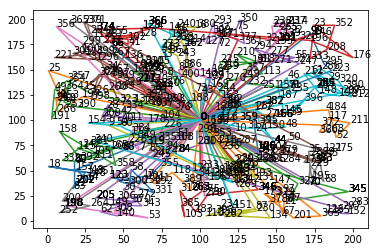

In [67]:
plotRoutes(rts)

In [196]:
def sumRoutes(routes):
    sum = 0
    for route in routes:
        sum += route.total_distance
    return sum

In [130]:
sumRoutes(rts)

867.3556123674309

Запишем результаты в выходной файл

In [71]:
def writeResults(problem, routes):
    f = open(problem.name + ".sol", "w")
    for route in routes:
        f.write(route.prePrintView()+"\n")

In [18]:
writeResults(problem, bestRoutes)

Применим написанное ранее для всех входных файлов

In [72]:
import sys
import os

In [73]:
def prepareData(walk_dir):
    for root, subdirs, files in os.walk(walk_dir):
        for filename in files:
            print(root + filename)
            problem = readData(root + filename)
            ils = IteratedLocalSearch(problem)
            bestRoutes = ils.execute()
            plotRoutes(bestRoutes)
            writeResults(problem, bestRoutes)

D://dt//R146.TXT


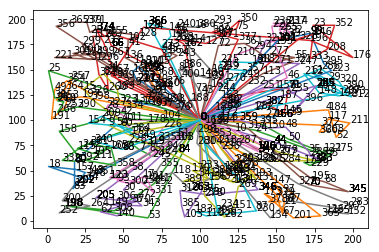

D://dt//R168.TXT


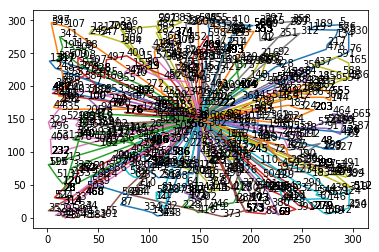

D://dt//R202.txt


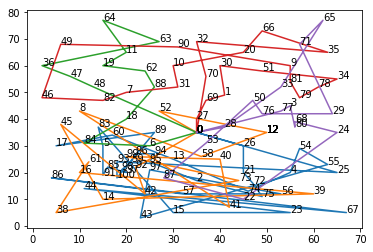

D://dt//RC105.txt


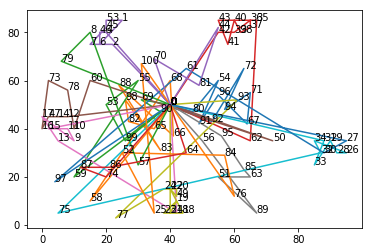

D://dt//RC148.TXT


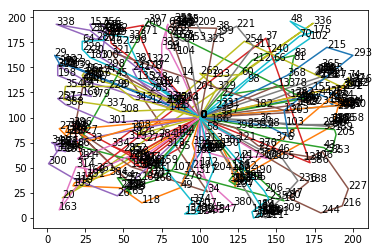

D://dt//RC207.txt


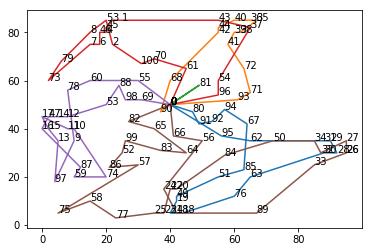

In [77]:
prepareData("D://dt//")

In [ ]:
for route in bestRoutes:
    print(route.prePrintView())